<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Quickstart: Web Cam Multi-Object Tracking


Multi-Object tracking is the canonical computer vision task of associating multiple detected objects from one frame to another within a video or a sequence of images.

This notebook shows a simple example of loading a pretrained tracking model for multi-object tracking and applying it to a short video. In particular, we will use [FairMOT](https://github.com/ifzhang/FairMOT) which is a state-of-the-art tracking model with high accuracy and inference speed.  

To understand the basics of Multi-Object-Tracking, please visit our [FAQ](FAQ.md).  For more details about training or  finetuning a pre-trained model, please see our [training introduction notebook](01_training_introduction.ipynb).

## Prerequisite for Webcam example 
This notebook assumes you have **a webcam** connected to your machine.  We use the `ipywebrtc` module to show the webcam widget in the notebook. Currently, the widget works on **Chrome** and **Firefox**. For more details about the widget, please visit `ipywebrtc` [github](https://github.com/maartenbreddels/ipywebrtc) or [documentation](https://ipywebrtc.readthedocs.io/en/latest/).

## Initialization
Import all the functions we need.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Regular Python Libraries
import os.path as osp
import sys
import urllib.request

# Third party tools
from ipywebrtc import CameraStream, VideoRecorder
from ipywidgets import HBox, Layout, widgets, Widget, VBox, Video
import torch
import torchvision

# Computer Vision repository
sys.path.append("../../")
from utils_cv.common.data import data_path
from utils_cv.common.gpu import which_processor, is_windows
from utils_cv.tracking.dataset import TrackingDataset
from utils_cv.tracking.model import (
    TrackingLearner,
    write_video,
    plot_single_frame,
    display_video,
)

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0a0+6b959ee
Torch is using GPU: Tesla K80


This shows your machine's GPUs (if it has any) and the computing device `torch/torchvision` is using.

Next, set some data input parameters.

In [17]:
MODEL_PATH = "./models/model_06.pth"  # The path to a saved tracking model
VID_URL = "https://cvbp.blob.core.windows.net/public/datasets/action_recognition/drinking.mp4"  # Example video to run inference on

# Load Model

 First we pass our tracking model into our TrackingLearner object. Note that the the tracking model has been finetuned on fridge objects (see how in our [training introduction notebook](01_training_introduction.ipynb)), such as the bottle in the example video.

In [18]:
tracker = TrackingLearner(None, MODEL_PATH)

# Object Tracking

## From Video File

To illustrate, a simple example of tracking objects, we use a video of a person drinking. 

In [7]:
# Download example video file
vid_path = osp.join(data_path(), "example_vid.mp4")
urllib.request.urlretrieve(VID_URL, vid_path)

Video.from_file(vid_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00RP\xa8mdat\x00\x00\…

Using the tracker's predict() method, we ask the tracking model to detect objects on each frame in this video, and associate them from one frame to another. 

Using the `predict()` method on each image in the sequence, we ask the model to detect how many objects and what they are on each image. The method returns annotation boxes that contains the bounding boxes around the identified objects, as well as the id number, whereby each new object acquires a new id number.


In [19]:
track_results = tracker.predict(vid_path, conf_thres=0.5, det_thres=0.3)

loaded ./models/model_06.pth, epoch 13


For example, frame 55, 56, 95 and 96 of the video are as follows:

[{Bbox object: [left=814, top=580, right=1023, bottom=1027] | frame: 55 | track: 1}]


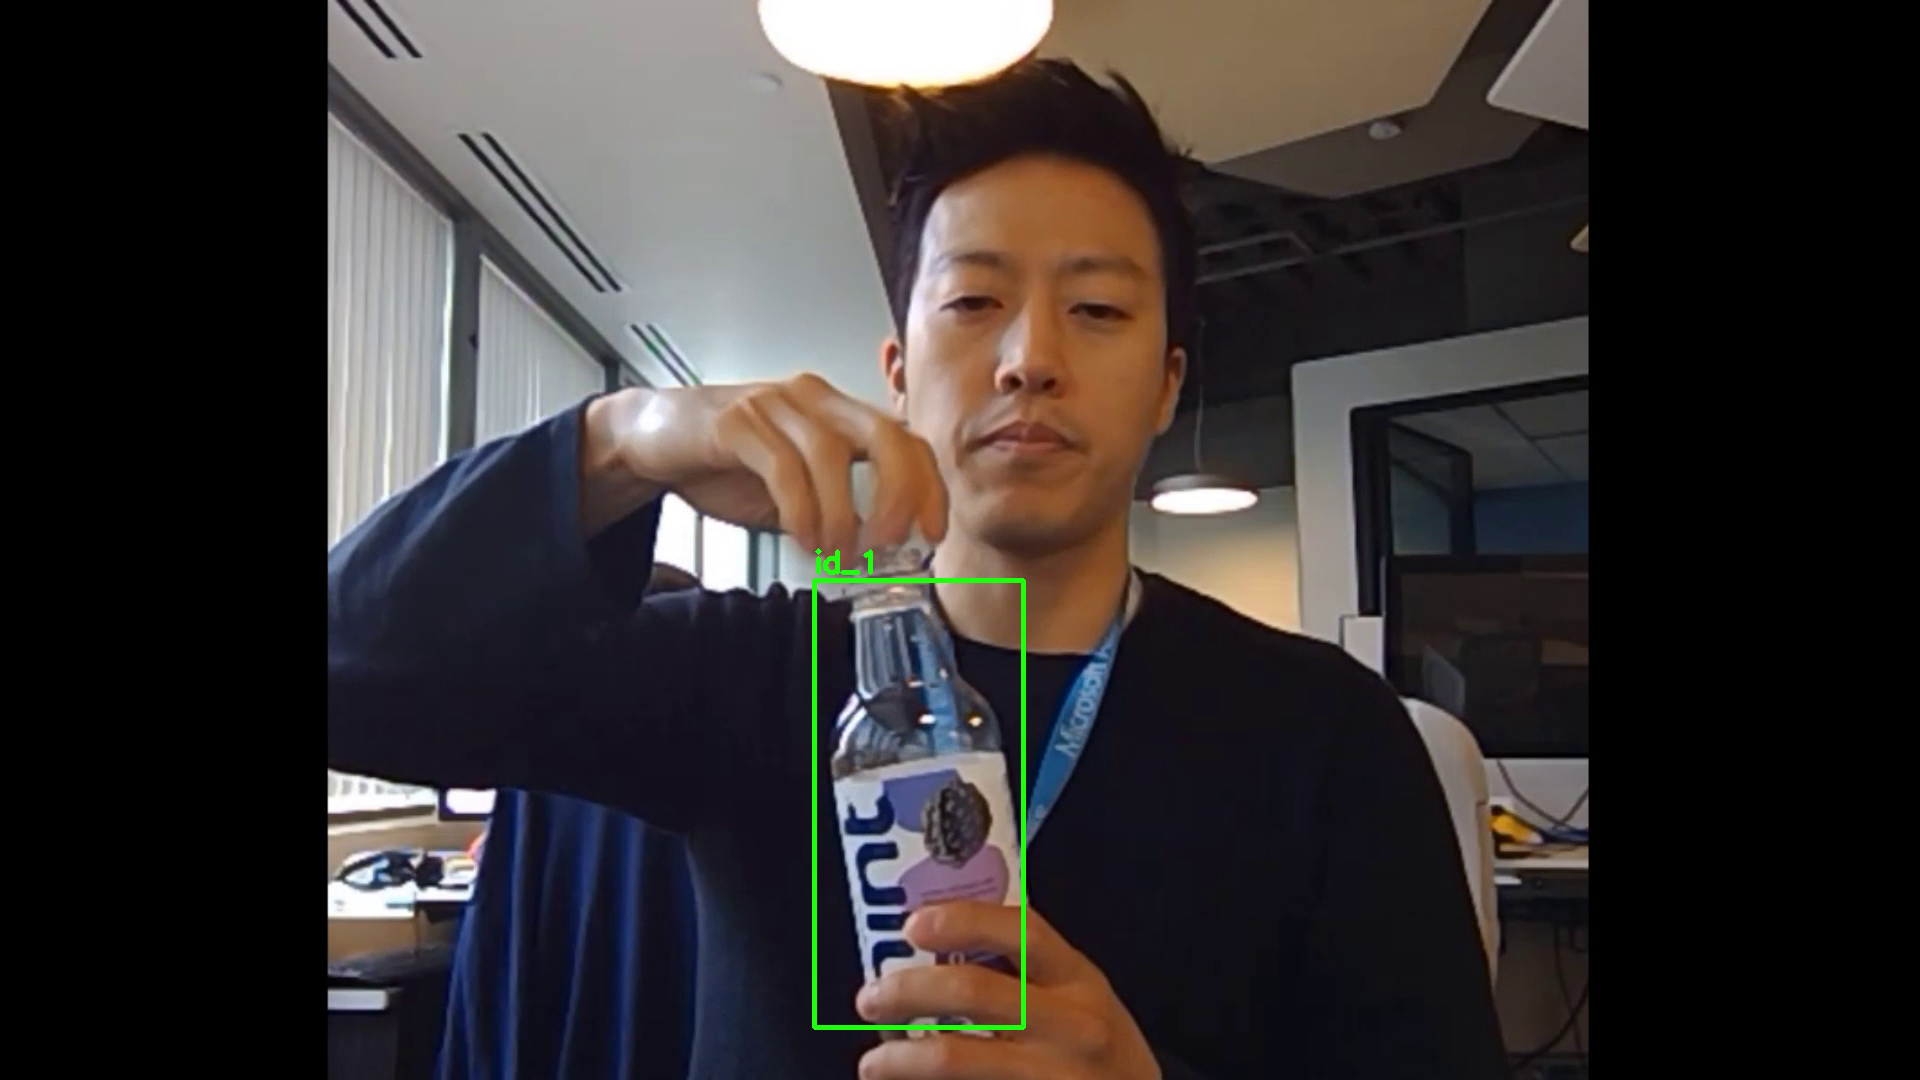

[{Bbox object: [left=817, top=585, right=1023, bottom=1025] | frame: 56 | track: 1}]


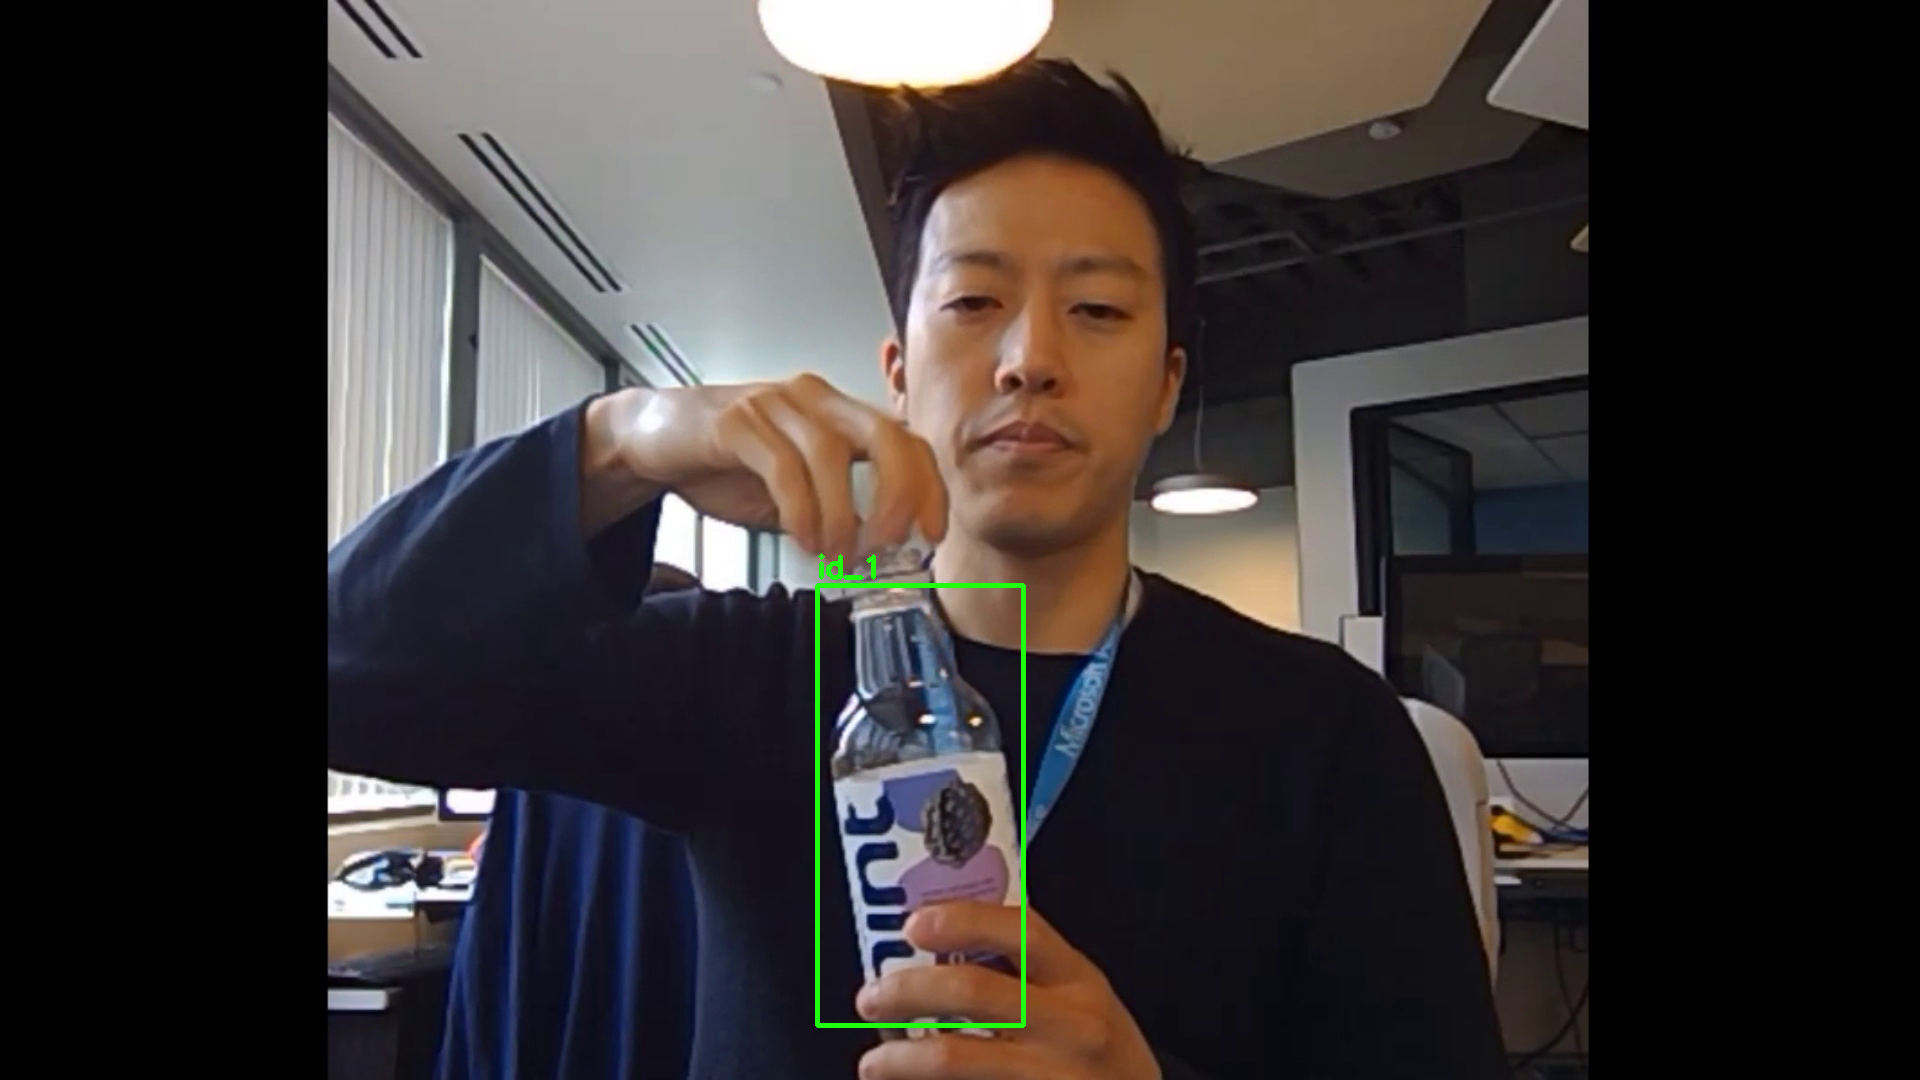

[{Bbox object: [left=963, top=181, right=1362, bottom=607] | frame: 95 | track: 6}]


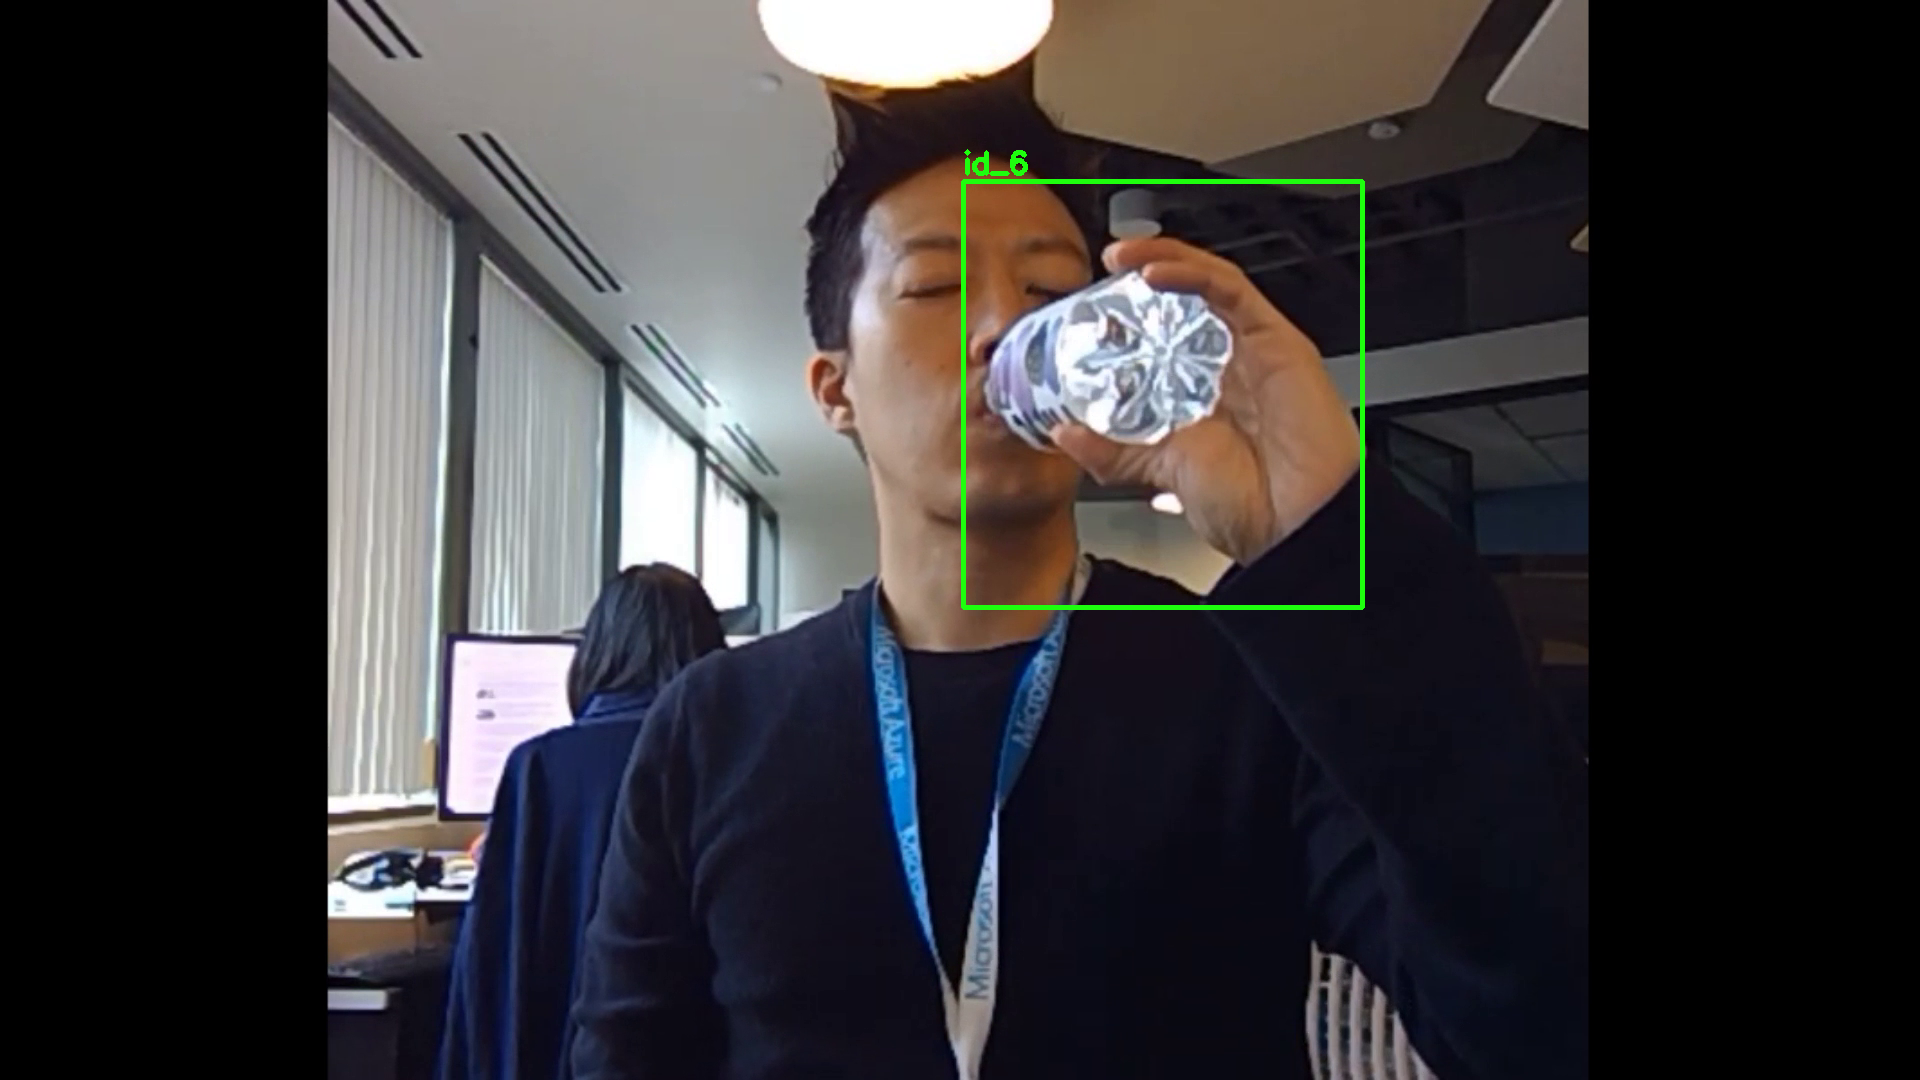

[{Bbox object: [left=964, top=181, right=1361, bottom=606] | frame: 96 | track: 6}]


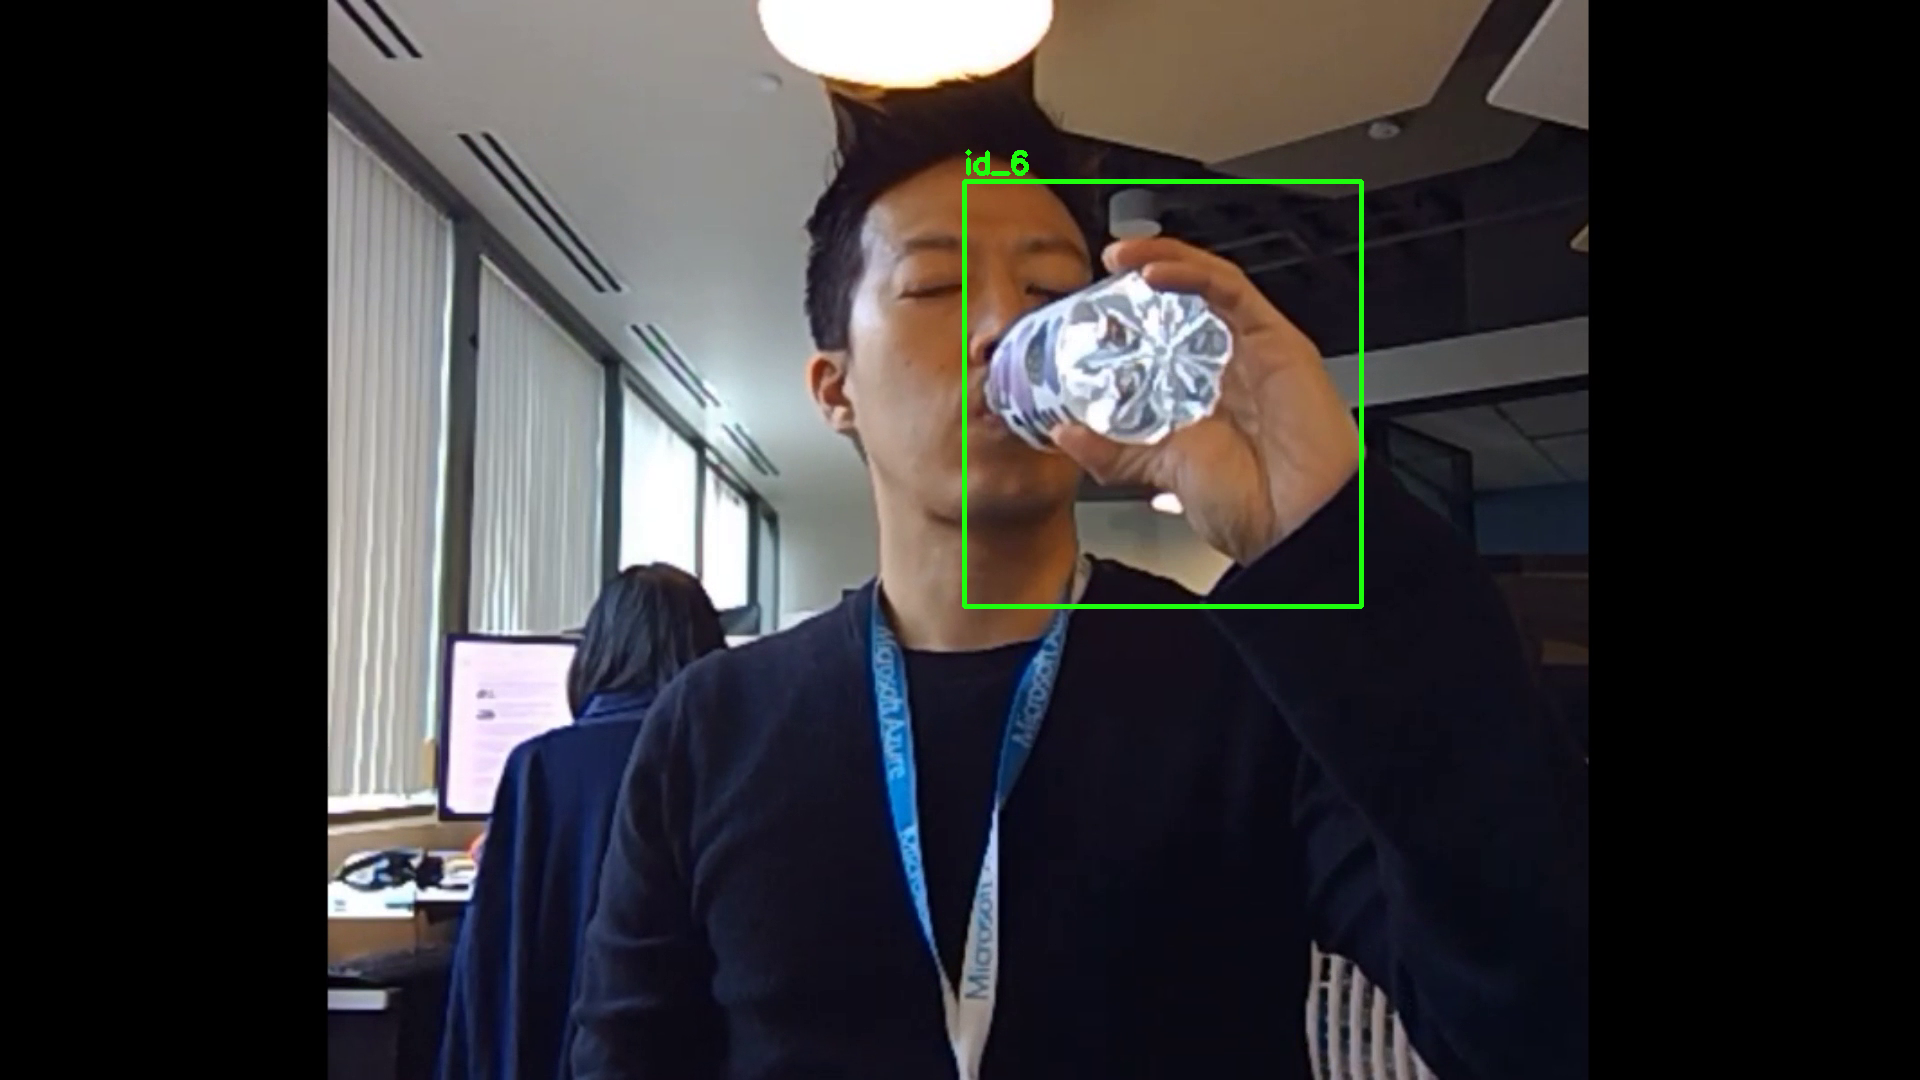

In [23]:
frame_list = [55, 56, 95, 96]

for frame_i in frame_list:
    print(track_results[frame_i])
    im = plot_single_frame(track_results, vid_path, frame_i)

We now overlay the generated tracking results onto the video. Let's visualize the resulting video:

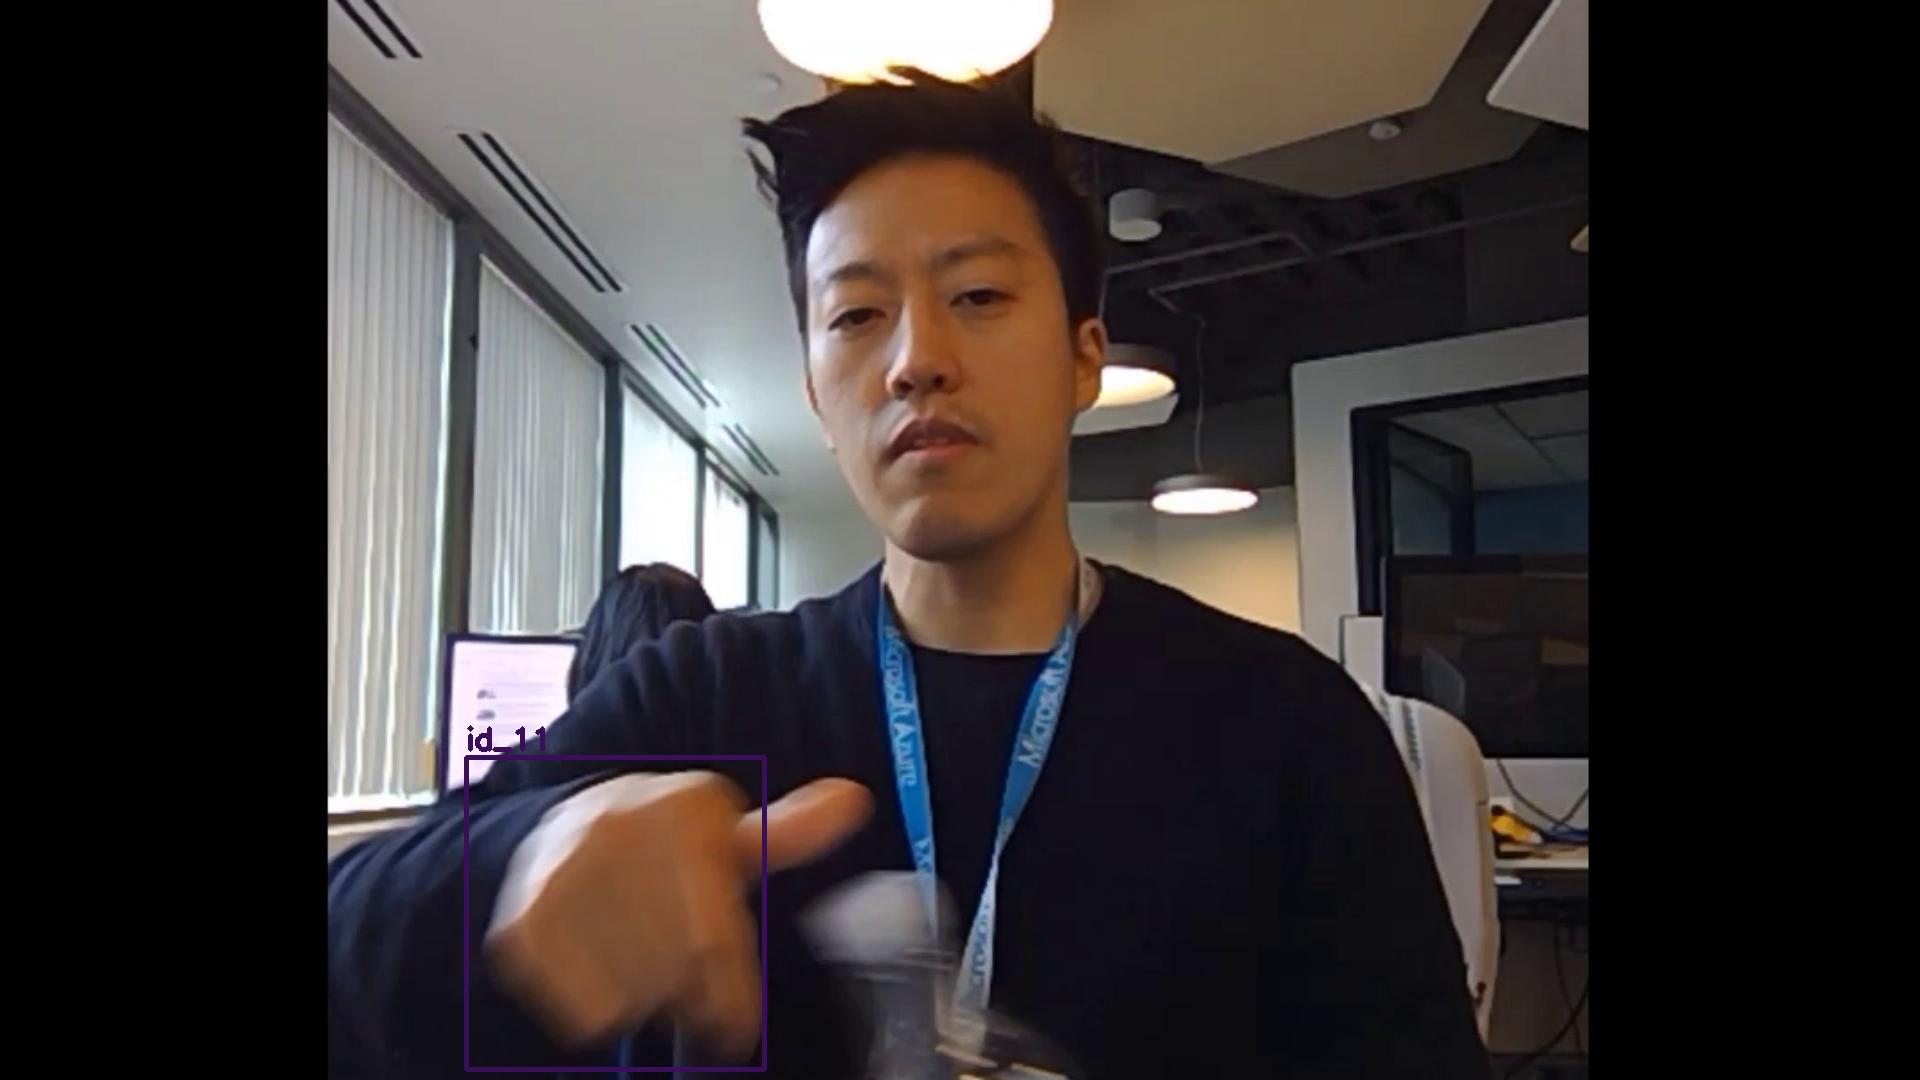

In [24]:
display_video(track_results, vid_path)

 We now save the resulting video, which you can download at the path set below.

In [25]:
output_video = osp.join(data_path(), "00_vid_tracked_model06.mp4")
write_video(track_results, vid_path, output_video)

Output saved to /data/home/maidapmot/blob_karineMOT/computervision-recipes/data/00_vid_tracked_model06.mp4.


## From WebCam Stream (TO DELETE because FairMOT does not  run on the corrupted captured video)

Now, we use a WebCam stream for object detection. We use `ipywebrtc` to start a webcam and get the video stream which is sent to the notebook's widget. Note that Jupyter widgets are quite unstable - if the widget below does not show, try different operating systems or browser, or see the "Troubleshooting" section in this [FAQ](../classification/FAQ.md) for possible fixes. 

In [ ]:
# Widget setup to record video stream
w_cam = CameraStream(
    constraints={
        "facing_mode": "user",
        "audio": False,
        "video": {"width": 200, "height": 200},
    },
    layout=Layout(width="200px"),
)
# Video recorder for taking a video stream
# w_imrecorder = VideoRecorder(stream=w_cam, layout=Layout(padding='0 0 0 50px')) #KIP
w_imrecorder = VideoRecorder(stream=w_cam)  # KIP
w_im = widgets.Image(layout=Layout(width="200px"))

# Show widgets
HBox([w_cam, w_imrecorder, w_im])

Now, click the **record button** in the rgiht widget above to start recording of the video you want using your webcam. Ckick on the **record button** again to stop the recording. You can view the recorded video using the **play button**.

Once satisfied with the recorded, save the recorded video:

In [ ]:
webcam_video_path = osp.join(data_path(), "example_webcam_0630.avi")
w_imrecorder.recording = False
w_imrecorder.save(webcam_video_path)

Next, run the following script to run the tracker on the recorded video. In the resulting video, bounding boxes are displayed to show the objects detected by the model, and the id number indicates the unique tracked object.

In [ ]:
webcam_video_path = (
    "/data/home/maidapmot/blob_karineMOT/computervision-recipes/data/carcans.mp4"
)
webcam_video_path = osp.join(data_path(), "example_webcam_0630.avi")
# Run inference on captured video
track_results = tracker.predict(webcam_video_path,)

# Generate video from tracking results
output_video = osp.join(data_path(), "example_webcam_tracked.mp4")
write_video(track_results, webcam_video_path, output_video)
Video.from_file(output_video)


# '/data/home/maidapmot/blob_karineMOT/computervision-recipes/data/carcans.mp4'

# Conclusion
In this notebook, we used a simple example to demonstrate how to use a trained tracking model to detect and track object(s) across frames in a video sequence. In the [training introduction notebook](01_training_introduction.ipynb), we will learn how to fine-tune or retrain a model on user-defined training dataset.

In [ ]:
# Stop the model and webcam
Widget.close_all()